In [52]:
%load_ext autoreload
%autoreload 2

In [1]:
# Example 1 - Getting familiar with the data
#
# This notebook focuses on just exploring the
# Visium data, in order to get a sense of 
# what it look likes. For more "interesting"
# analysis see Example 2 and 3.
#
# Some custom python modules written for
# these examples are included - thus make sure
# you've cloned the whole rep.

In [2]:
# Load modules/libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import helpers
import stx as stx
import utils as ut

In [3]:
# Start by loading the data

cnt_pth ="../_data/Allen-2/Allen-2-count-matrix.tsv.gz" # count data
img_pth = "../_data/Allen-2/tissue_hires_image.png" # HE-image
jsn_pth = "../_data/Allen-2/scalefactors_json.json" #json file with additional info


# For ease of usage an STdata class has
# been implemented, providing some
# basic features for data handling

data = stx.STdata(cnt = cnt_pth,
                  img = img_pth,
                  scf = jsn_pth,
                  )

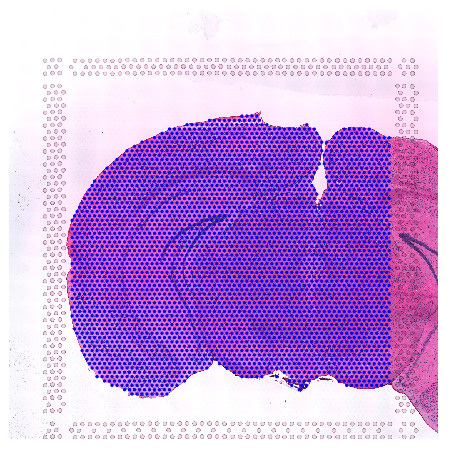

In [4]:
# Overlaying the spots on the HE-image
# we get the following image

ax, fig = data.plot(figsize = (8,8),
                    marker_size = 5,
                    )

plt.show()

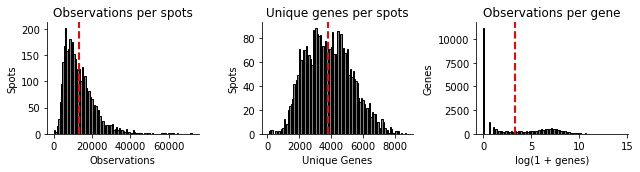

In [5]:
# To assess the quality of our data
# we can plot some basic metrics -
# just to make sure our data is ok


fig, ax = plt.subplots(1,
                       3,
                       figsize = (9,2.5))

# plot number of observed transcripts per spot
stx.obs_per_spot(data.cnt,
                 ax = ax[0])

# plot number of unique genes per spot
stx.unique_genes_per_spot(data.cnt,
                          ax = ax[1])

# plot number of transcripts per gene
stx.obs_per_gene(data.cnt,
                 ax = ax[2])

fig.tight_layout()

In [6]:
# Furthermore we can look at the
# top 10 highest expressed genes

top10 = stx.topNgenes(data.cnt)
ut.fancy_print(top10)

,Rank,SumTotal,Mean
Bc1,1,1657991,464.293195
mt-Co3,2,1341532,375.674041
mt-Co1,3,1250460,350.170820
mt-Co2,4,785121,219.860263
mt-Atp6,5,739507,207.086810
mt-Cytb,6,558240,156.325959
mt-Nd4,7,460717,129.016242
mt-Nd1,8,404853,113.372445
mt-Nd2,9,361188,101.144777
Fth1,10,331431,92.811817


In [7]:
# There's a high presence of mithocondrial genes
# Using regex we can filter these.
# We will also fitler ribosomal proteins, whilst at it 
# as well as removing some genes with very low
# expression

# define pattern for genes to remove
pattern = '^(Rp)|^(mt)'
# filter data
data.filter_genes(pattern,
                  min_tot = 100,
                  min_obs = 10,
                 )
# get top 10 most expressed, post filtration
top10 = stx.topNgenes(data.cnt)
ut.fancy_print(top10)

,Rank,SumTotal,Mean
Bc1,1,1657991,464.293195
Fth1,2,331431,92.811817
Cst3,3,207027,57.974517
Ppia,4,164038,45.936152
Tmsb4x,5,155646,43.586110
Gapdh,6,154299,43.208905
Ubb,7,139317,39.013442
Cox6c,8,119037,33.334360
Calm2,9,115635,32.381686
Calm1,10,114114,31.955755


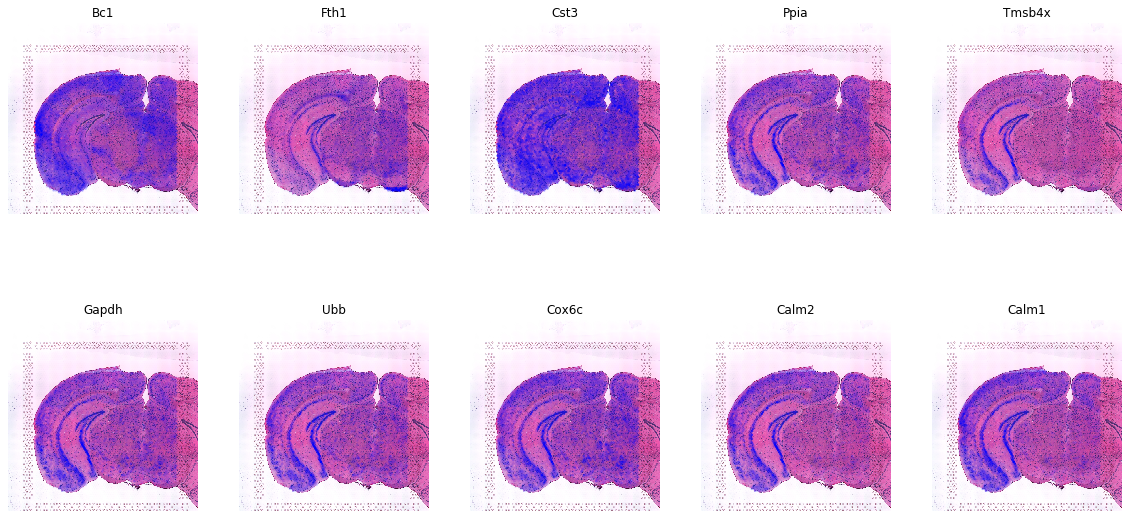

In [8]:
# Next, we can visualize the spatial
# distribution of these top 10 genes

fig,ax = plt.subplots(2,
                      5,
                      figsize = (20,10))
ax = ax.flatten()

# to visualize the gene expression of each gene
# we'll update the feature of interest (foi)
# and then use the plot method of the STdata class

for k,gene in enumerate(top10.index.values):
    data.set_foi(gene) 
    data.plot(marker_size = 3,
              fig = fig,
              ax = ax[k],
             ) 

<IPython.core.display.Javascript object>


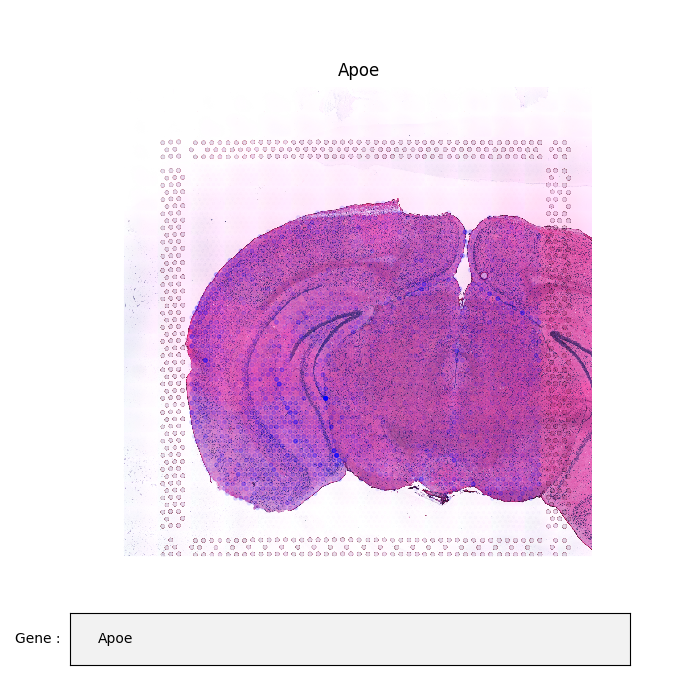

In [9]:
# We could also inspect any gene of our choice in
# a more interactive way.

%matplotlib notebook

from matplotlib.widgets import TextBox

# Initialize Interactive plot
initial_text = "Apoe"

data.set_foi(initial_text)

ifig, iax = plt.subplots(1,1,
                         figsize=(7,7))

data.plot(marker_size = 8,
          ax = iax,
          fig = ifig)

# define action on submission
def submit(text):
    if not isinstance(text,str):
        print("[ERROR] : Enter gene name")
    else:
        data.set_foi(text)
        iax.clear()
        data.plot(marker_size = 10,
                  ax = iax,
                  fig = ifig)
        plt.draw()
        
# add text box for gene input
axbox = plt.axes([0.1, 0.05, 0.8, 0.075])
plt.subplots_adjust(bottom=0.2)

text_box = TextBox(axbox,
                   'Gene : ',
                   initial=initial_text,)

text_box.on_submit(submit)
# plot
plt.show()

In [10]:
%matplotlib inline

# For an initial quick analysis we could also
# cluster the spots based on their expression
# profiles.

np.random.seed(1337)

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
import umap

n_clusters = 12

dimred = FastICA(n_components = 40)
km = KMeans(n_clusters = n_clusters)

# First we normalize the data
ncnt = stx.normalize_cnt(data.cnt.values)
# Project data to a 20 dim space
ncnt = dimred.fit_transform(ncnt)
# Cluster the data
cidx = km.fit_predict(ncnt)
# Project into 2 dim space for visualization
umap_crd = umap.UMAP().fit_transform(ncnt)


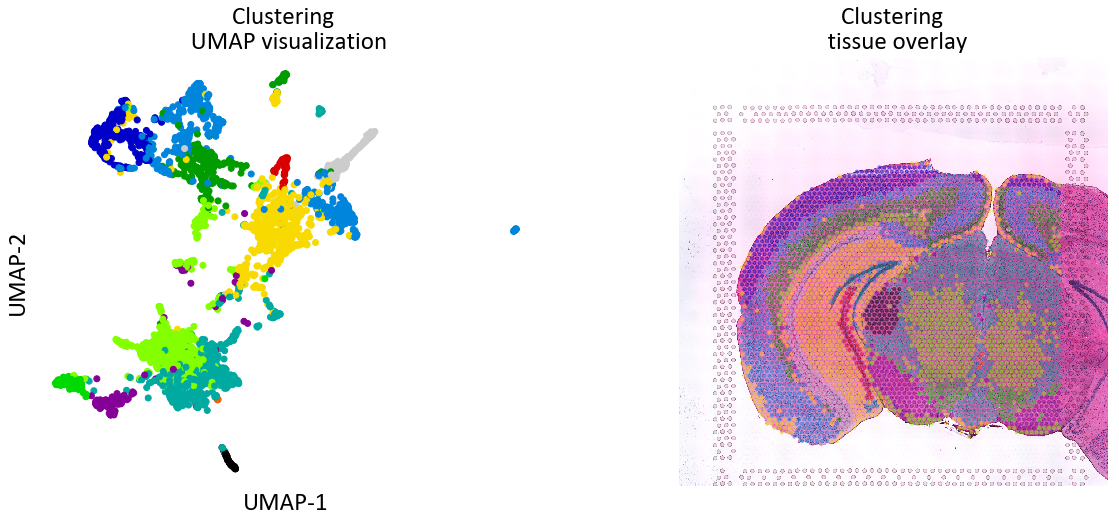

In [11]:
# Inspect the clustering result by plotting
# them; this can be done both 
# w.r.t. to the UMAP embedding
# as well as actual physical coordinates

# Set plot specs
cmap = plt.cm.nipy_spectral
data.set_foi(cidx)
style_dict = {'fontsize':25,
              'fontfamily':'Calibri'}


fig, ax = plt.subplots(1,2,
                       figsize = (20,8))

# Visualize clusters in reduced space
ax[0].scatter(umap_crd[:,0],
              umap_crd[:,1],
              c = cidx,
              cmap = cmap)

# clean up plot
ut.clean_spines(ax[0],)
ut.clean_ticks(ax[0])

# label plot
ax[0].set_title("Clustering \n UMAP visualization",
                **style_dict)
ax[0].set_xlabel("UMAP-1",**style_dict)
ax[0].set_ylabel("UMAP-2",**style_dict)


# Visualize clusters on tissue
_,ax[1] = data.plot(marker_size = 10, 
                   cmap = cmap,
                   ax = ax[1],
                   fig = fig,
                    alpha = 0.4,
                   )

ax[1].set_title("Clustering \n tissue overlay",
                **style_dict)

plt.show()


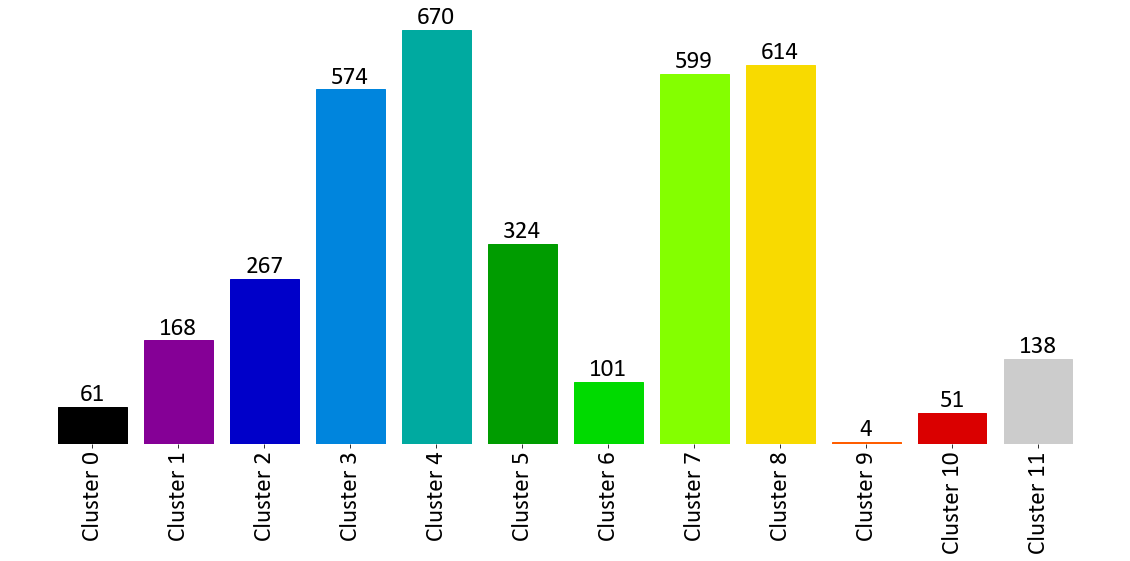

In [12]:
# The number of members in each clusters
# are given below

fig, ax = ut.plot_member_distribution(cidx,
                                      cmap = cmap,
                                      style_dict  = style_dict)

plt.show()

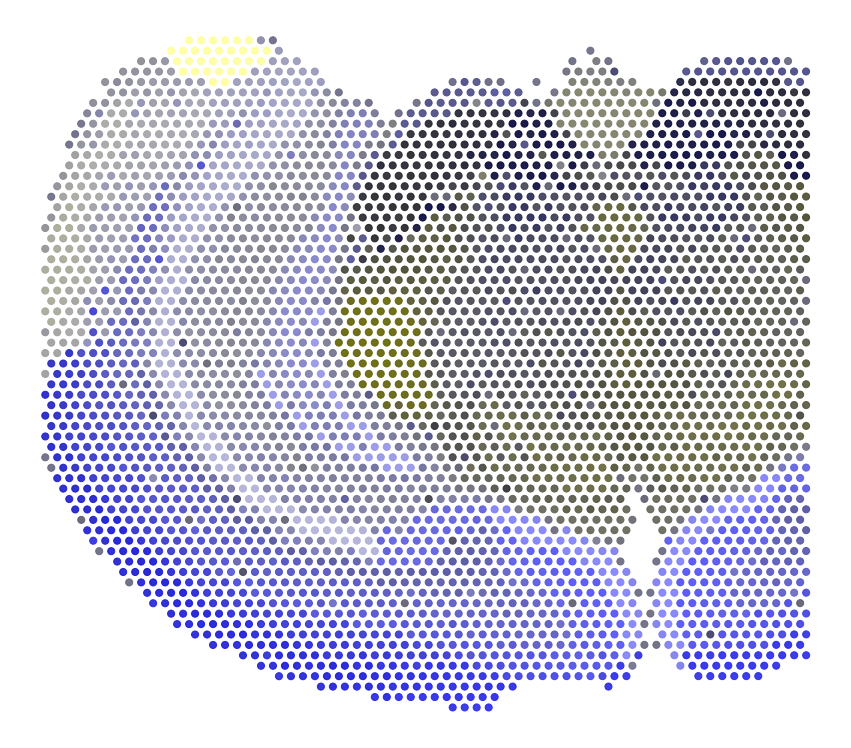

In [13]:
# For a smoother visualization we
# could use the UMAP projections
# to color our spots

# map UMAP projections to unit square

rgb = np.zeros((data.S,3))
mn = umap_crd.min(axis=0).reshape(1,-1)
mx = umap_crd.max(axis=0).reshape(1,-1)
rgb[:,1:3] = (umap_crd  - mn) / (mx - mn)
rgb[:,0] = rgb[:,1]
# set feature of interest
data.set_foi(rgb)
# plot
fig, ax = data.plot(marker_size = 50,
                    figsize = (15,15),
                    alpha = 0.9,
                    overlay = False,
                   )